                              backend   N  depth   iter_time   exp_value  \
0   pennylane_lightning:lightning.gpu   4      3    0.107015   13.074179   
1   pennylane_tensor:lightning.tensor   4      3    4.108026   13.074179   
2                  tensorcircuit_full   4      3    0.051713   13.074177   
3                   tensorcircuit_mps   4      3    2.973906   15.414001   
4   pennylane_lightning:lightning.gpu   8      3    0.353608   25.354977   
5   pennylane_tensor:lightning.tensor   8      3   27.741002   25.152117   
6                  tensorcircuit_full   8      3    0.120378   25.354977   
7                   tensorcircuit_mps   8      3   15.778788   26.212049   
8   pennylane_lightning:lightning.gpu  16      3    1.281670   72.515068   
9   pennylane_tensor:lightning.tensor  16      3  144.712533   69.511673   
10                 tensorcircuit_full  16      3    0.368556   72.515076   
11                  tensorcircuit_mps  16      3   80.527674   75.470604   
12  pennylan

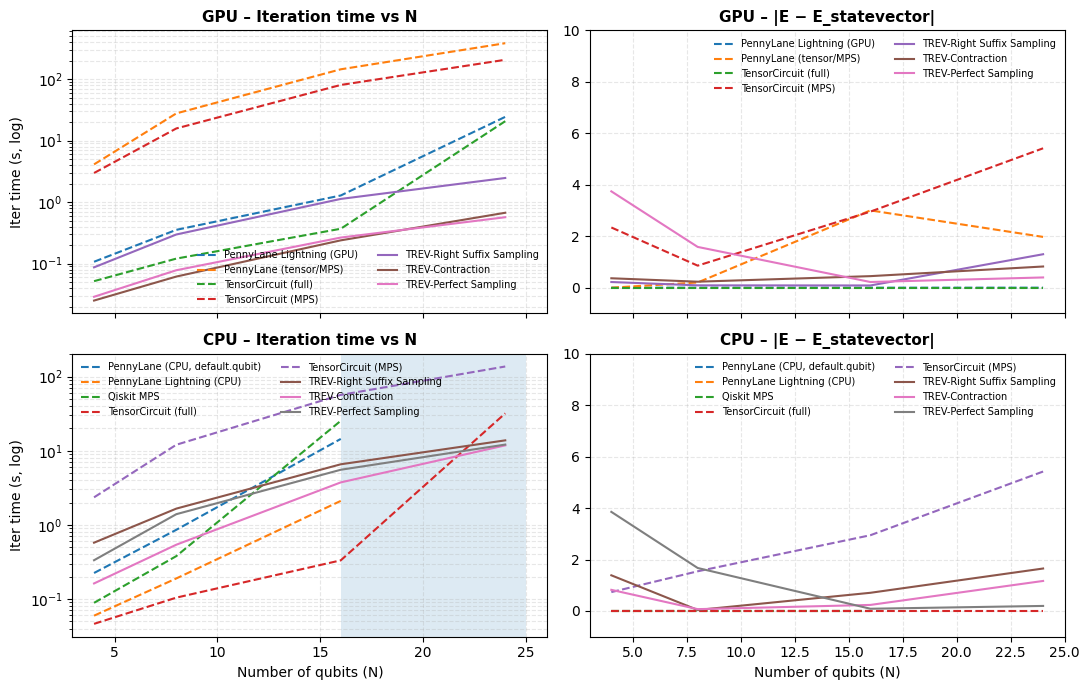

In [91]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

root = Path("lib_comp")

# ----------------------------------------------------
# 1) load the four sources
# ----------------------------------------------------
cpu_base = pd.read_csv(root / "bench_out_comparison_cpu_real" / "summary.csv")
gpu_base = pd.read_csv(root / "bench_out_comparison_gpu" / "summary.csv")

cpu_maxcut = pd.read_csv(root / "maxcut_comparison_CPU" / "summary.csv")
gpu_maxcut = pd.read_csv(root / "maxcut_comparison_GPU" / "summary.csv")

# maxcut_* has 'method' column, not 'library'
# normalize columns to a common 'backend' column
cpu_maxcut = cpu_maxcut.rename(columns={"method": "backend"})
gpu_maxcut = gpu_maxcut.rename(columns={"method": "backend"})

cpu_base = cpu_base.rename(columns={"library": "backend"})
gpu_base = gpu_base.rename(columns={"library": "backend"})
gpu_base = gpu_base[gpu_base['depth'] == 3]
# add source tags
cpu_base["source"] = "cpu_base"
gpu_base["source"] = "gpu_base"
cpu_maxcut["source"] = "cpu_maxcut"
gpu_maxcut["source"] = "gpu_maxcut"

# merge
cpu_all = pd.concat([cpu_base, cpu_maxcut], ignore_index=True)
gpu_all = pd.concat([gpu_base, gpu_maxcut], ignore_index=True)

# ----------------------------------------------------
# 2) helper to load iter csv and get median iter_time + final exp
# ----------------------------------------------------
def load_iter_stats(row):
    iter_path = root / row["iter_csv"]
    df = pd.read_csv(iter_path)
    med_time = df["iter_time"].median()
    final_exp = df["exp_value"].iloc[-1]
    return med_time, final_exp

def build_df(df_all):
    rows = []
    for _, r in df_all.iterrows():
        med_time, final_exp = load_iter_stats(r)
        rows.append({
            "backend": r["backend"],
            "N": int(r["N"]),
            "depth": int(r["depth"]),
            "iter_time": med_time,
            "exp_value": final_exp,
            "source": r["source"],
        })
    return pd.DataFrame(rows)
gpu_all = gpu_all[gpu_all['depth'] == 3]
gpu_all= gpu_all[gpu_all['seed'] == 0]
cpu_all = cpu_all[~cpu_all["backend"].str.contains("quimb:mps", case=False)]
cpu_df = build_df(cpu_all)
gpu_df = build_df(gpu_all)
#gpu_df = build_df(gpu_all)

# ----------------------------------------------------
# 3) find baselines per N
#    - for maxcut_*: Statevector is baseline
#    - otherwise: first statevector-like backend
# ----------------------------------------------------
def pick_baseline(df, N):
    # prefer explicit "Statevector"
    cand = df[(df["N"] == N) & (df["backend"].str.contains("Statevector", case=False))]
    if not cand.empty:
        return cand.iloc[0]["exp_value"]
    # else: pick tensorcircuit_full or pennylane statevector
    cand = df[(df["N"] == N) & (
        df["backend"].str.contains("tensorcircuit_full") |
        df["backend"].str.contains("lightning.qubit") |
        df["backend"].str.contains("default.qubit")
    )]
    if not cand.empty:
        return cand.iloc[0]["exp_value"]
    return None

def build_acc_df(df):
    rows = []
    for N in sorted(df["N"].unique()):
        base_val = pick_baseline(df, N)
        if base_val is None:
            continue
        for _, r in df[df["N"] == N].iterrows():
            err = abs(r["exp_value"] - base_val)
            rows.append({
                "backend": r["backend"],
                "N": N,
                "error": err,
            })
    return pd.DataFrame(rows)
print(gpu_df)
cpu_acc = build_acc_df(cpu_df)
gpu_acc = build_acc_df(gpu_df)

def remove_sv(df):
    return df[~df["backend"].str.contains("sv", case=False)]
cpu_acc = remove_sv(cpu_acc)
gpu_acc = remove_sv(gpu_acc)
cpu_df = remove_sv(cpu_df)
gpu_df = remove_sv(gpu_df)
print(gpu_df)
#print(cpu_acc)
# ----------------------------------------------------
# 4) ACM colors + mapping
# ----------------------------------------------------
# acm_colors = {
#     "statevector": "#0072B2",
#     "mps": "#E69F00",
#     "tensorcircuit": "#009E73",
#     "pennylane": "#CC79A7",
#     "quimb": "#616161",
#     "trev": "#D55E00",
# }

# def color_for(backend: str):
#     b = backend.lower()
#     if "trev" in b:
#         return acm_colors["trev"]
#     if "statevector" in b:
#         return acm_colors["statevector"]
#     if "tensorcircuit" in b:
#         return acm_colors["tensorcircuit"]
#     if "pennylane" in b or "lightning" in b or "default.qubit" in b:
#         return acm_colors["pennylane"]
#     if "qiskit" in b or "mps" in b:
#         return acm_colors["mps"]
#     if "quimb" in b:
#         return acm_colors["quimb"]
#     return "#000000"

def label_for(backend: str):
    b = backend
    if backend.lower() == "trev":
        return "Our TREV (Tensor Ring VQE)"
    if "Statevector" in backend:
        return "Statevector (MaxCut)"
    if "tensorcircuit_full" in backend:
        return "TensorCircuit (full)"
    if "tensorcircuit_mps" in backend:
        return "TensorCircuit (MPS)"
    if "pennylane_default" in backend:
        return "PennyLane (CPU, default.qubit)"
    if "lightning.qubit" in backend:
        return "PennyLane Lightning (CPU)"
    if "lightning.gpu" in backend:
        return "PennyLane Lightning (GPU)"
    if "pennylane_tensor" in backend:
        return "PennyLane (tensor/MPS)"
    if "qiskit_mps" in backend:
        return "Qiskit MPS"
    if "quimb" in backend:
        return "Quimb MPS"
    if "tr_efficient" in backend:
        return "TREV-Contraction"
    if "tr_sampling" in backend:
        return "TREV-Perfect Sampling"
    if "tr_correct_sampling" in backend:
        return "TREV-Right Suffix Sampling"
    return backend

# ----------------------------------------------------
# 5) plot 2x2 with TREV last & thick
# ----------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex='col')

# order backends so that TREV is last
def sorted_backends(df):
    backs = df["backend"].unique().tolist()
    backs_no_trev = [b for b in backs if b.lower() != "trev"]
    backs_no_trev.sort()
    backs_no_trev.append("TREV")
    return [b for b in backs_no_trev if b in backs]

# GPU time
ax = axes[0,0]
for backend in sorted_backends(gpu_df):
    sub = gpu_df[gpu_df["backend"] == backend].sort_values("N")
    #col = color_for(backend)
    ls = "-" if backend.lower()[:2] in ["tr"] else "--"
    ax.plot(sub["N"], sub["iter_time"], linestyle=ls, label=label_for(backend))
ax.set_yscale("log")
ax.set_ylabel("Iter time (s, log)")
ax.set_title("GPU – Iteration time vs N", fontsize=11, fontweight="bold")
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.legend(fontsize=7, frameon=False, ncol=2)

# GPU accuracy
ax = axes[0,1]
for backend in sorted_backends(gpu_acc):
    sub = gpu_acc[gpu_acc["backend"] == backend].sort_values("N")
    #col = color_for(backend)
    ls = "-" if backend.lower()[:2] in ["tr"] else "--"
    ax.plot(sub["N"], sub["error"], linestyle=ls, label=label_for(backend))
    ax.set_title("GPU – |E − E_statevector|", fontsize=11, fontweight="bold")
ax.grid(True, which="both", ls="--", alpha=0.3)

ax.legend(fontsize=7, frameon=False, ncol=2)
ax.set_ylim([-1, 1e1])
# CPU time
ax = axes[1,0]
for backend in sorted_backends(cpu_df):
    sub = cpu_df[cpu_df["backend"] == backend].sort_values("N")
    ls = "-" if backend.lower()[:2] in ["tr"] else "--"
    ax.plot(sub["N"], sub["iter_time"],linestyle=ls, label=label_for(backend))
ax.set_yscale("log")
ax.set_xlabel("Number of qubits (N)")
ax.set_ylabel("Iter time (s, log)")
ax.set_title("CPU – Iteration time vs N", fontsize=11, fontweight="bold")
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.legend(fontsize=7, frameon=False, ncol=2)
ax.axvspan(25, 16, alpha=0.15, label="Statevector infeasible region")
# CPU accuracy
ax = axes[1,1]
for backend in sorted_backends(cpu_acc):
    sub = cpu_acc[cpu_acc["backend"] == backend].sort_values("N")
    ls = "-" if backend.lower()[:2] in ["tr"] else "--"
    ax.plot(sub["N"], sub["error"], linestyle=ls, label=label_for(backend))
ax.set_xlabel("Number of qubits (N)")
#ax.set_yscale("log")
ax.set_title("CPU – |E − E_statevector|", fontsize=11, fontweight="bold")
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.legend(fontsize=7, frameon=False, ncol=2)
ax.set_ylim([-1, 1e1])
plt.tight_layout()
plt.show()


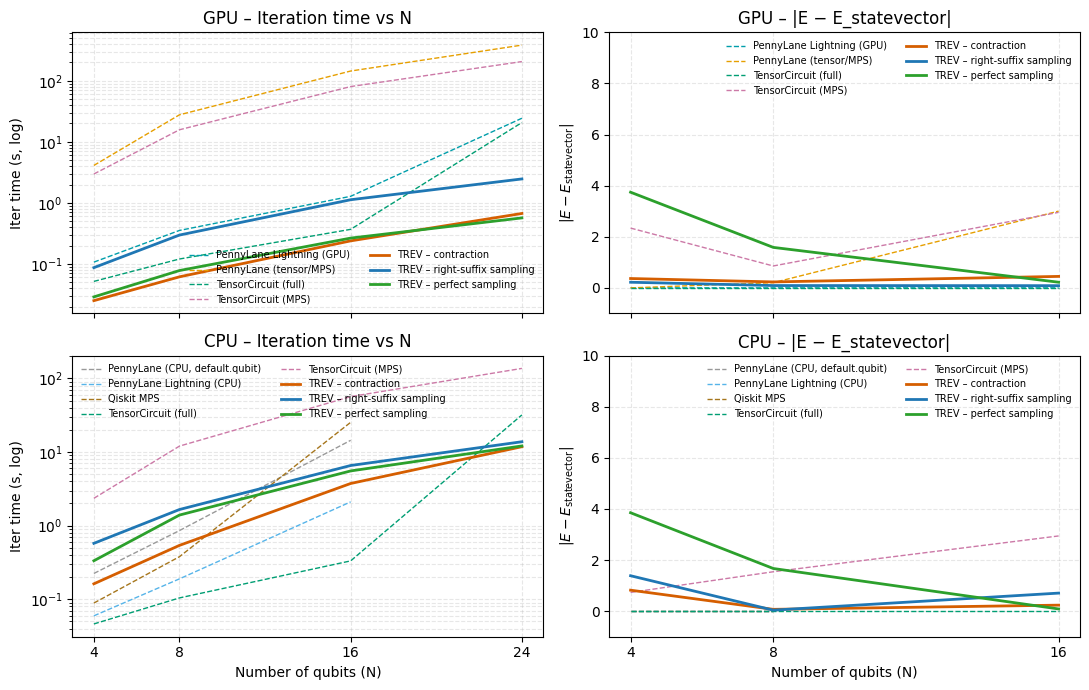

In [103]:
import matplotlib.pyplot as plt

# ------------- build global backend list -------------
all_backends = (
    list(gpu_df["backend"].unique()) +
    list(cpu_df["backend"].unique()) +
    list(gpu_acc["backend"].unique()) +
    list(cpu_acc["backend"].unique())
)
# keep order but dedupe
seen = set()
ordered_backends = []
for b in all_backends:
    if b not in seen:
        seen.add(b)
        ordered_backends.append(b)

# ------------- make a per-backend color map -------------
# 11–12 good distinct colors (ACM-ish + extra)
palette = [
    "#009EAA",  # blue
    "#E69F00",  # orange
    "#009E73",  # green
    "#CC79A7",  # purple
    "#D55E00",  # red
    "#1F77B4",  # light blue
    "#2CA02C",  # black
    "#999999",  # gray
    "#56B4E9",  # teal
    "#A6761D",  # brown
    "#D62728",  # magenta-ish
    "#1B9E77",  # extra green
]

backend_to_color = {}
for i, b in enumerate(ordered_backends):
    backend_to_color[b] = palette[i % len(palette)]

def label_for(backend: str):
    if "tr_efficient" in backend:
        return "TREV – contraction"
    if "tr_sampling" in backend:
        return "TREV – perfect sampling"
    if "tr_correct_sampling" in backend:
        return "TREV – right-suffix sampling"
    if "tensorcircuit_full" in backend:
        return "TensorCircuit (full)"
    if "tensorcircuit_mps" in backend:
        return "TensorCircuit (MPS)"
    if "pennylane_default" in backend:
        return "PennyLane (CPU, default.qubit)"
    if "lightning.qubit" in backend:
        return "PennyLane Lightning (CPU)"
    if "lightning.gpu" in backend:
        return "PennyLane Lightning (GPU)"
    if "pennylane_tensor" in backend:
        return "PennyLane (tensor/MPS)"
    if "qiskit_mps" in backend:
        return "Qiskit MPS"
    return backend

def is_trev(backend: str) -> bool:
    return backend.lower().startswith("tr_")

def sorted_backends(df):
    # plot all non-TREV first, then TREV on top
    backs = list(df["backend"].unique())
    non_trev = sorted([b for b in backs if not is_trev(b)])
    trev = [b for b in backs if is_trev(b)]
    return non_trev + trev

fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex="col")


# GPU time
ax = axes[0,0]
for backend in sorted_backends(gpu_df):
    sub = gpu_df[gpu_df["backend"] == backend].sort_values("N")
    col = backend_to_color[backend]
    ls = "-" if backend.lower()[:2] in ["tr"] else "--"
    lw = 2 if backend.lower()[:2] in ["tr"] else 1
    ax.plot(sub["N"], sub["iter_time"], linestyle=ls, lw = lw, label=label_for(backend), color=col)
ax.set_yscale("log")
ax.set_ylabel("Iter time (s, log)")
ax.set_title("GPU – Iteration time vs N")
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.legend(fontsize=7, frameon=False, ncol=2)

# GPU accuracy
ax = axes[0,1]
for backend in sorted_backends(gpu_acc):
    sub = gpu_acc[gpu_acc["backend"] == backend].sort_values("N")
    col = backend_to_color[backend]
    ls = "-" if backend.lower()[:2] in ["tr"] else "--"
    lw = 2 if backend.lower()[:2] in ["tr"] else 1
    ax.plot(sub["N"][:-1], sub["error"][:-1], linestyle=ls,lw = lw, label=label_for(backend), color=col)
    ax.set_title("GPU – |E − E_statevector|")
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.set_ylabel(r"$|E - E_{\mathrm{statevector}}|$")
ax.set_title("GPU – |E − E_statevector|")
ax.legend(fontsize=7, frameon=False, ncol=2)
ax.set_ylim([-1, 1e1])
# CPU time
ax = axes[1,0]
for backend in sorted_backends(cpu_df):
    sub = cpu_df[cpu_df["backend"] == backend].sort_values("N")
    col = backend_to_color[backend]
    ls = "-" if backend.lower()[:2] in ["tr"] else "--"
    lw = 2 if backend.lower()[:2] in ["tr"] else 1
    ax.plot(sub["N"], sub["iter_time"],linestyle=ls, lw = lw, label=label_for(backend), color=col)
ax.set_yscale("log")
ax.set_xlabel("Number of qubits (N)")
ax.set_ylabel("Iter time (s, log)")
ax.set_title("CPU – Iteration time vs N")
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.legend(fontsize=7, frameon=False, ncol=2)
#ax.axvspan(25, 16, alpha=0.15, label="Statevector infeasible region")
ax.set_xticks([4,8,16,24])
# CPU accuracy
ax = axes[1,1]
for backend in sorted_backends(cpu_acc):
    sub = cpu_acc[cpu_acc["backend"] == backend].sort_values("N")
    col = backend_to_color[backend]
    ls = "-" if backend.lower()[:2] in ["tr"] else "--"
    lw = 2 if backend.lower()[:2] in ["tr"] else 1
    ax.plot(sub["N"][:-1], sub["error"][:-1], linestyle=ls, lw = lw, label=label_for(backend), color=col)
ax.set_xlabel("Number of qubits (N)")
#ax.set_yscale("log")
ax.set_title("CPU – |E − E_statevector|")
ax.set_ylabel(r"$|E - E_{\mathrm{statevector}}|$")
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.legend(fontsize=7, frameon=False, ncol=2)
ax.set_ylim([-1, 1e1])
ax.set_xticks([4,8,16])
plt.tight_layout()

fig.savefig(
    "data/lib_comp.png",
    dpi=600,                # 600+ for publication quality
    bbox_inches="tight",    # trims whitespace
    pad_inches=0.05,
)
plt.show()
